In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import glob
import keras
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Load in images

In [2]:
unblocked_images = []
for img in glob.glob("img/unblocked/*.png"):
    n= cv2.imread(img, flags=cv2.IMREAD_ANYDEPTH)
    unblocked_images.append(n)

In [3]:
unblocked_images = np.array(unblocked_images)

In [4]:
unblocked_images.shape

(362, 480, 752)

In [5]:
blocked_images_all = []
for img in glob.glob("img/blocked/*/*.png"):
    n = np.array(cv2.imread(img, flags=cv2.IMREAD_ANYDEPTH))
    blocked_images_all.append(n)

In [6]:
blocked_images_all = np.array(blocked_images_all)

In [7]:
blocked_images_all.shape

(354, 480, 752)

In [8]:
len(blocked_images_all) / (len(blocked_images_all) + len(unblocked_images))

0.49441340782122906

In [9]:
np.max(blocked_images_all)

37924

## Create X and y arrays (input and output) and shuffle them

In [10]:
y_unblocked = np.full(len(unblocked_images), 0)
y_blocked = np.full(len(blocked_images_all), 1)
y_all = np.concatenate((y_unblocked, y_blocked))

In [11]:
X_all = np.concatenate((unblocked_images, blocked_images_all), axis=0)

In [12]:
X_all.shape

(716, 480, 752)

In [13]:
shuf_ind = np.random.permutation(len(y_all))
X_all = X_all[shuf_ind].reshape((len(y_all),X_all.shape[1],X_all.shape[2],1))
y_all = y_all[shuf_ind]

X_all.shape

(716, 480, 752, 1)

In [14]:
np.median(X_all)

10000.0

In [15]:
print(np.max(X_all))
X_all[X_all == 10000] = 40000
print(np.max(X_all))

37924
40000


In [16]:
X_all = (40000 - X_all)
X_all = X_all / 40000
X_all

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [17]:
np.max(X_all)

0.9926

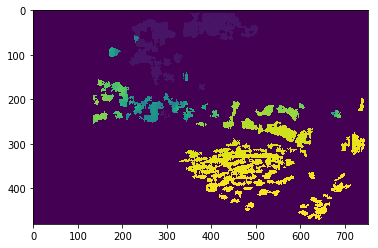

In [18]:
plt.imshow((X_all[0]).reshape((480,752)))

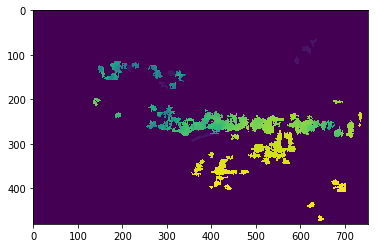

In [19]:
plt.imshow((X_all[600]).reshape((480,752)))

## Set up model and train

In [20]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (4,4), activation='relu', input_shape=(X_all.shape[1],X_all.shape[2], 1)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(4, (4,4), activation='relu'),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.MaxPool2D((2, 2)),
    #
    keras.layers.Flatten(),  
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 477, 749, 16)      272       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 238, 374, 16)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 119, 187, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 184, 4)       1028      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 58, 92, 4)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 46, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5336)            

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [22]:
model.fit(X_all, y_all, validation_split=0.2, epochs=5, batch_size=8)


Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 120s 210ms/step - loss: 0.5246 - accuracy: 0.7587 - val_loss: 0.4478 - val_accuracy: 0.8125
Epoch 2/5
572/572 [==============================] - 96s 167ms/step - loss: 0.3586 - accuracy: 0.8479 - val_loss: 0.3768 - val_accuracy: 0.8333
Epoch 3/5
572/572 [==============================] - 85s 148ms/step - loss: 0.2632 - accuracy: 0.8899 - val_loss: 0.3690 - val_accuracy: 0.8403
Epoch 4/5
572/572 [==============================] - 96s 168ms/step - loss: 0.1637 - accuracy: 0.9493 - val_loss: 0.7875 - val_accuracy: 0.7431
Epoch 5/5
572/572 [==============================] - 132s 230ms/step - loss: 0.0877 - accuracy: 0.9703 - val_loss: 0.5391 - val_accuracy: 0.7917


## Save model and weights

In [23]:
# serialize weights to HDF5
model.save("blocked_model.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
model.predict(X_all[9].reshape((1,480,752,1)))

array([[0.9584094]], dtype=float32)

In [25]:
X_all[0].reshape((1,480,752,1))

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]])